In [1]:
import numpy as np
import scipy.linalg as  la
%matplotlib inline
import matplotlib.pyplot as plt
import time
import hamiltonian as hm

In [156]:
def chop(a):
    if not np.all(np.isclose(np.imag(a),0)): 
        print("\nchop() removed the imaginary part\n ")
    A = np.round(np.real(a),3)
    if np.all(np.isclose(A.astype(int), A)): return A.astype(int)
    else: return A

In [4]:
def norm(A):
    norm = np.trace(A @ A.T.conj())/(len(A))
    assert np.isclose(np.imag(norm),0)
    return np.real(norm)

In [5]:
def tensor(*args):
    A = 1
    for arg in args:
        A = np.kron(A, arg)
    return A

In [6]:
def par_tr(x,i):
    N = len(x)
    assert 2**i < N
    
    indices = np.array(range(N))
    bit = int((N/2)/2**i)
    mask = N - (bit) - 1
    indices = indices & mask
    return (x[:,np.unique(indices)][np.unique(indices)] + 
            x[:,np.unique(indices + bit)][np.unique(indices + bit)])/2

In [144]:
# Trace out the last/first i spins
def end_trace(x, i):
    N = len(x)
    untraced = (int) (N/2**i)
    traced = 2**i
    x = x.reshape((untraced, traced, untraced, traced))
    return np.trace(x, axis1=1, axis2=3)/2**i
def front_trace(x, i):
    N = len(x)
    untraced = (int) (N/2**i)
    traced = 2**i
    x = x.reshape((traced, untraced, traced, untraced))
    return np.trace(x, axis1=0, axis2=2)/2**i

In [8]:
def sparse_Hmult(l):
    if (l==3): return H3mult
#     print(np.shape(np.kron(sparse_Hmult(l-2),I2)))
#     print(np.shape(np.kron(np.eye(l-3), H3mult)))
    return np.kron(sparse_Hmult(l-2),I2) + np.kron(np.eye(2**(l-3)), H3mult)

def sparse_ham(l):
    if (l%2 != 1): assert False, "l must be odd"
    H = sparse_Hmult(l)
    return H * (2j * np.pi)/(3 * np.sqrt(3))

# 3-Site system

In [17]:
H3mult = np.array([[0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 0],
               [0 ,  0 ,  1 ,  0 , -1 ,  0 ,  0 , 0],
               [0 , -1 ,  0 ,  0 ,  1 ,  0 ,  0 , 0],
               [0 ,  0 ,  0 ,  0 ,  0 , -1 ,  1 , 0],
               [0 ,  1 , -1 ,  0 ,  0 ,  0 ,  0 , 0],
               [0 ,  0 ,  0 ,  1 ,  0 ,  0 , -1 , 0],
               [0 ,  0 ,  0 , -1 ,  0 ,  1 ,  0 , 0],
               [0 ,  0 ,  0 ,  0 ,  0 ,  0 ,  0 , 0]])
H3 = H3mult * (2j * np.pi)/(3 * np.sqrt(3))

I = np.array([[ 1,  0],[ 0,  1]])
X = np.array([[ 0,  1],[ 1,  0]])
Y = np.array([[ 0,-1j],[1j,  0]])
Z = np.array([[ 1,  0],[ 0, -1]])

I2 = np.kron(I,I)

In [8]:
vals, vecs = la.eigh(H3)
eners = np.diag(vals)
vecsd = vecs.T.conj()

In [9]:
print(np.all(np.isclose(vecs@eners@vecsd, H3)))

True


In [10]:
unit3t = vecs@np.diag(np.exp(-1j*vals))@vecsd
print(chop(unit3t))

[[1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]


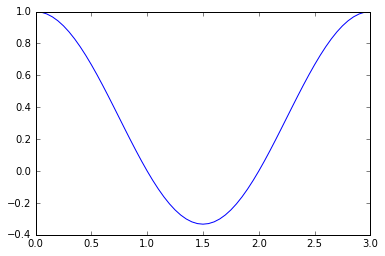

In [11]:
end = 3
n = 20
N = n*end
first = np.empty(N)
second = np.empty(N)
third = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit3t = vecs@np.diag(np.exp(-1j*vals*t))@vecsd
    first[i] = np.real(unit3t[1,1])
    second[i] = np.real(unit3t[4,1])
    third[i] = np.real(unit3t[2,1])
#     print(t)

plt.plot(np.arange(N)/n, first)
plt.show()
# print(first)

### 3-Site Tsunami
##### Make gate, evolve in time, trace out different spins, rinse, repeat

In [12]:
# Total time elapsed
end = 3
# Time steps per second
n = 6
N = n*end
A = np.kron(np.kron(Z,I),I)

weight0 = np.empty(N)
weight1 = np.empty(N)
weight2 = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit3t = vecs@np.diag(np.exp(-1j*vals*t))@vecsd
    At = np.linalg.inv(unit3t) @ A @ unit3t
#     print(chop(unit3t),"\n")
    
    weight0[i] = 1 - norm(par_tr(At,0))
    weight1[i] = 1 - norm(par_tr(At,1))
    weight2[i] = 1 - norm(par_tr(At,2))

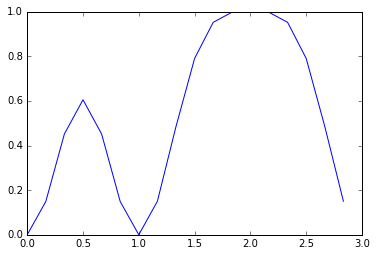

In [13]:
plt.plot(np.arange(N)/n,weight1)
plt.show()

# 5-Site

In [18]:
H5mult = np.kron(H3mult,np.kron(I,I)) + np.kron(np.kron(I,I),H3mult)
H5 = H5mult * (2j * np.pi)/(3 * np.sqrt(3))

In [19]:
vals5, vecs5 = la.eigh(H5)
eners5 = np.diag(vals5)
vecsd5 = vecs5.T.conj()

In [20]:
unit5 = vecs5@np.diag(np.exp(-1j*vals5))@vecsd5
print(chop(unit5[:10,:10]))

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.105  0.944 -0.     0.192  0.    -0.     0.    -0.249  0.   ]
 [ 0.    -0.181  0.105  0.     0.571  0.    -0.     0.     0.754  0.   ]
 [ 0.     0.    -0.     0.202  0.     0.109  0.64   0.     0.    -0.386]
 [ 0.     0.571  0.192  0.    -0.525  0.    -0.     0.     0.571  0.   ]
 [ 0.     0.     0.     0.64   0.    -0.463  0.04   0.     0.     0.294]
 [ 0.    -0.    -0.     0.109 -0.     0.359 -0.463  0.    -0.     0.277]
 [ 0.     0.     0.    -0.     0.     0.     0.     0.202  0.     0.   ]
 [ 0.    -0.249  0.008  0.     0.192  0.    -0.     0.     0.105  0.   ]
 [ 0.     0.     0.    -0.195  0.     0.106  0.086 -0.     0.    -0.253]]


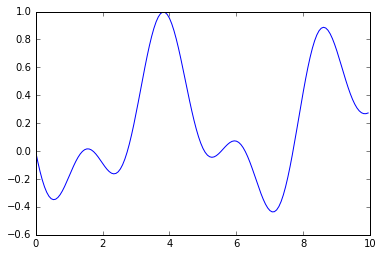

In [21]:
end = 10
n = 15
N = n*end
first = np.empty(N)
second = np.empty(N)
third = np.empty(N)

for i in np.arange(N):
    t = i/n
    unit5t = vecs5@np.diag(np.exp(-1j*vals5*t))@vecsd5
    first[i] = np.real(unit5t[1,1])
    second[i] = np.real(unit5t[4,1])
    third[i] = np.real(unit5t[2,1])
#     print(t)

plt.plot(np.arange(N)/n, third)
plt.show()
# print(first)

### 5-Site Tsunami
##### Make gate, evolve in time, trace out different spins, rinse, repeat

In [151]:
# Total time elapsed
end = 2
# Time steps per second
n = 20
N = n*end
A5 = np.kron(np.kron(Z,I),np.kron(np.kron(I,I),I))
B5 = np.kron(np.kron(I,I),np.kron(np.kron(I,I),Z))

weightfore = np.empty((5, N))
weightback = np.empty((5, N))

for i in np.arange(N):
    t = i/n
    unit5t = vecs5@np.diag(np.exp(-1j*vals5*t))@vecsd5
    A5t = np.linalg.inv(unit5t) @ A5 @ unit5t
    B5t = np.linalg.inv(unit5t) @ B5 @ unit5t
#     print(chop(unit3t),"\n")
    front = norm(A5t)
    back  = norm(B5t)
    
    for j in range(5):
#         A5t = par_tr(A5t,5-j-1)
        A5t = end_trace(A5t,1)
        B5t = front_trace(B5t,1)
        fronthere = norm(A5t)
        backhere  = norm(B5t)
        weightfore[5-1-j,i] = front - fronthere
        weightback[j,i]     = back  - backhere
        front = fronthere
        back  = backhere

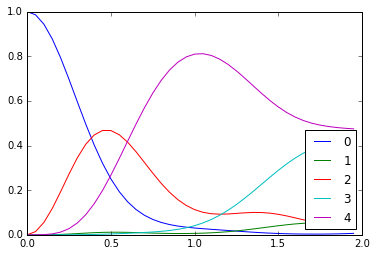

In [152]:
for i in range(5):
    plt.plot(np.arange(N)/n,weightfore[i], label = str(i))
plt.legend(loc=4)
plt.show()

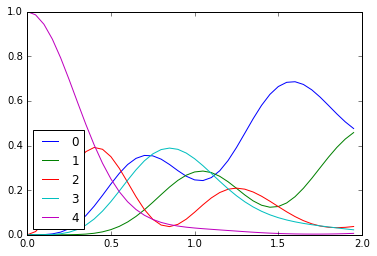

In [153]:
for i in range(5):
    plt.plot(np.arange(N)/n,weightback[i], label = str(i))
plt.legend(loc=3)
plt.show()

# Time Usage

In [42]:
L = 9

H = hm.sparse_H(L)
vals, vecs = la.eigh(H)
eners = np.diag(vals)
vecsd = vecs.T.conj()

# Total time elapsed
end = 3
# Time steps per second
n = 20
N = n*end
A = hm.Z
for i in range(L-1):
    A = np.kron(A,hm.I)
B = hm.Z
for i in range(L-1):
    B = np.kron(hm.I,B)

weightfore9 = np.empty((L, N))
weightback9 = np.empty((L, N))

for i in np.arange(N):
    t = i/n
    unitt = np.dot(np.dot(vecs,  np.diag(np.exp(-1j*vals*t))), vecsd)
    unitt = la.expm(-1j*H*t)
    At    = np.dot(np.dot(np.linalg.inv(unitt), A),             unitt)
    Bt    = np.dot(np.dot(np.linalg.inv(unitt), B),             unitt)
#     print(chop(unit3t),"\n")
    front = hm.norm(At)
    back  = hm.norm(Bt)
    
    for j in range(L):
        At = hm.end_trace(At,1)
        Bt = hm.front_trace(Bt,1)
        fronthere = hm.norm(At)
        backhere  = hm.norm(Bt)
        weightfore9[L-1-j, i] = front - fronthere
        weightback9[j, i]     = back  - backhere
        front = fronthere
        back  = backhere

In [29]:
# with @ operator
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      29.43 s.
  System :       1.20 s.
Wall time:      15.51 s.


In [5]:
# with np.matmul
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      27.76 s.
  System :       1.08 s.
Wall time:      14.48 s.


In [39]:
# with np.dot
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      28.58 s.
  System :       1.11 s.
Wall time:      14.99 s.


In [48]:
# with expm
%run -t timeHamiltonian.py


IPython CPU timings (estimated):
  User   :      56.23 s.
  System :       4.50 s.
Wall time:      30.46 s.


In [6]:
%run -p timeHamiltonian.py

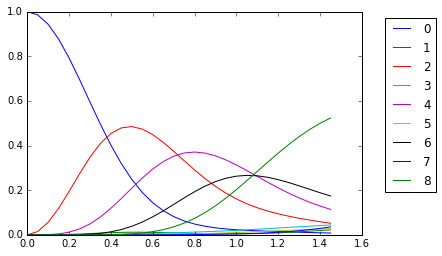

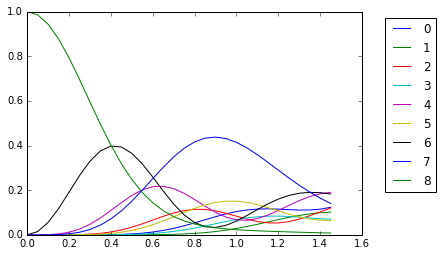

In [43]:
end = (int) (n*1.5)

for i in range(L):
    plt.plot(np.arange(end)/n,weightfore9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

for i in range(L):
    plt.plot(np.arange(end)/n,weightback9[i,:end], label = str(i))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [52]:
print(np.count_nonzero(H))
print(np.shape(H)[0]**2)

3072
262144
